In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import pickle
import time

from rdkit import Chem
from rdkit.Chem import Draw


fp_radius = 2
fp_bits = 4096

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

2023-07-06 16:03:58.429855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 16:03:58.613089: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from Transformer.Transformer import Transformer, create_look_ahead_mask, create_padding_mask, create_masks, CustomSchedule, evaluate, loss_function, BeamSearch 
from ChemUtils.PreProcessing import read_file, smiles_to_fp_array, CHAR_LEN, array_to_smiles

# Define Model and Load Weights

In [3]:
smiles_array, fp_array = read_file("Data/train.csv", useCount=True, fp_bits=fp_bits)

#with open("Data/train_dupli_count.pkl",  'rb') as pf:
    #trains = pickle.load(pf)

BATCH_SIZE = 200

gen = tf.data.Dataset.from_tensor_slices((smiles_array, fp_array))
gen = gen.shuffle(buffer_size=smiles_array.shape[0])
gen = gen.batch(BATCH_SIZE)

AUTOTUNE = tf.data.experimental.AUTOTUNE
gen = gen.prefetch(buffer_size=AUTOTUNE)

2023-07-06 16:05:43.106170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 16:05:43.424885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [4]:
num_layers = 6
d_model = 256
num_heads = 8
dff = 2048
input_vocab_size=fp_bits+3
target_vocab_size = CHAR_LEN+3
pe_input = fp_array.shape[1]
pe_target= smiles_array.shape[1]
rate = 0.1
EPOCHS=35

transformer = Transformer(num_layers, d_model, num_heads, dff, 
                    input_vocab_size, target_vocab_size,
                    pe_input, pe_target, rate)

checkpoint_path = "./checkpoints/FPsToSMILES(DupliCount)/train"

ckpt = tf.train.Checkpoint(transformer=transformer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# restore
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


# Reconstruct

In [5]:
smiles_array, fp_array = read_file("Data/test.csv", useCount=True, fp_bits=fp_bits)
BATCH_SIZE = 200

gen = tf.data.Dataset.from_tensor_slices((smiles_array,fp_array))
gen = gen.batch(BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE
gen = gen.prefetch(buffer_size=AUTOTUNE)

outputs = []

for i, data in enumerate(gen):
    batch_size= tf.shape(data[1])[0]
    output, attention_weights = evaluate(transformer, data[1], target_vocab_size-2, batch_size, 80)
    outputs.append(output)
    
    print("complete: %d/%d"%(i*BATCH_SIZE + batch_size, smiles_array.shape[0]))

2023-07-06 16:05:46.646374: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


complete: 200/5000
complete: 400/5000
complete: 600/5000
complete: 800/5000
complete: 1000/5000
complete: 1200/5000
complete: 1400/5000
complete: 1600/5000
complete: 1800/5000
complete: 2000/5000
complete: 2200/5000
complete: 2400/5000
complete: 2600/5000
complete: 2800/5000
complete: 3000/5000
complete: 3200/5000
complete: 3400/5000
complete: 3600/5000
complete: 3800/5000
complete: 4000/5000
complete: 4200/5000
complete: 4400/5000
complete: 4600/5000
complete: 4800/5000
complete: 5000/5000


In [6]:
re_smiles = []
for output in outputs:
    re_smiles.extend(array_to_smiles(output.numpy(), target_vocab_size-1))

true_smiles = array_to_smiles(smiles_array, target_vocab_size-1)
print(len(true_smiles), len(re_smiles))

5000 5000


In [7]:
mols = [Chem.MolFromSmiles(x) for x in re_smiles]
mols_=[x for x in mols if x is not None]
print(len(mols), len(mols_), "vaild smiles rate:", len(mols_)/len(mols))

[16:09:59] SMILES Parse Error: unclosed ring for input: 'CCOc1ccc(OCC)c(C2C(C#N)=C(N)N(c3ccccc3C(F)(F)F)C3=C2C2C(=O)CCC3)c1'
[16:09:59] SMILES Parse Error: unclosed ring for input: 'O=C1N=C(SCC2Nc3ccccc3C3=NC=NC32)N=C2c1ccc(Cl)cc1'
[16:09:59] SMILES Parse Error: extra close parentheses while parsing: CC(C)N(C)C(=O)C1CSCN1C(=O)C=CC1=CC(C)C)ccc1
[16:09:59] SMILES Parse Error: Failed parsing SMILES 'CC(C)N(C)C(=O)C1CSCN1C(=O)C=CC1=CC(C)C)ccc1' for input: 'CC(C)N(C)C(=O)C1CSCN1C(=O)C=CC1=CC(C)C)ccc1'
[16:09:59] SMILES Parse Error: extra close parentheses while parsing: CN(Cc1ccno1)CN1CC[NH+](C2CCCCC2)CC1)CCN(C(=O)c1nc2ccccn2c1F
[16:09:59] SMILES Parse Error: Failed parsing SMILES 'CN(Cc1ccno1)CN1CC[NH+](C2CCCCC2)CC1)CCN(C(=O)c1nc2ccccn2c1F' for input: 'CN(Cc1ccno1)CN1CC[NH+](C2CCCCC2)CC1)CCN(C(=O)c1nc2ccccn2c1F'
[16:09:59] SMILES Parse Error: extra close parentheses while parsing: c1cc2c(cc1-c1nc3c4cn[nH]c4ncn3n1)CCC4)cc1ccc(COc2)cc1
[16:09:59] SMILES Parse Error: Failed parsing SMILES 'c1

5000 4924 vaild smiles rate: 0.9848


[16:10:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 9 25 26
[16:10:00] SMILES Parse Error: extra open parentheses for input: 'O=S(=O)(c1cc(Cl)c(N2CCN(c3cc(C(F)(F)F)cc[nH+]3)CC2)s1'
[16:10:00] SMILES Parse Error: unclosed ring for input: 'O=c1cc([O-])c2c(-c3cccnc3)c3c4c(sc3n1)CCCC4'
[16:10:00] SMILES Parse Error: extra open parentheses for input: 'CC1CC2=C(CCCCC2=O)OC(N)=C2CC3(CCC(C)(C)CC3=O)c3cccc(c3n12'
[16:10:00] SMILES Parse Error: unclosed ring for input: 'O=c1[nH]c([O-])nnc-2c1C([N+](=O)[O-])=NO'
[16:10:00] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C2C(C#N)=C(N)N=C3C2C(=O)CCC3)cc1OC1CCCc2sc3c(c21)C1'
[16:10:00] SMILES Parse Error: unclosed ring for input: 'O=C(C=Cc1ccccc1)N(Cc1ccc(N(Cc2ccccc2)C(=O)Cc2ccccc2)cc1)C1'


In [8]:
re_can_smiles = []
count=0
for i,mol in enumerate(mols):
    if mol is not None:
        re_can_smiles.append(Chem.MolToSmiles(mol, isomericSmiles=False))
    else:
        re_can_smiles.append("")
        
    if re_can_smiles[i]==true_smiles[i]:
        count +=1
        
print("match: %d/%d,  %1.3f"%(count,len(true_smiles), count/len(true_smiles)))

match: 4491/5000,  0.898


# Draw incorrect Mols

In [9]:
dsmiles = []
tsmiles = []
for i,s in enumerate(re_can_smiles):
    if s != true_smiles[i]:
        dsmiles.append(s)
        tsmiles.append(true_smiles[i])

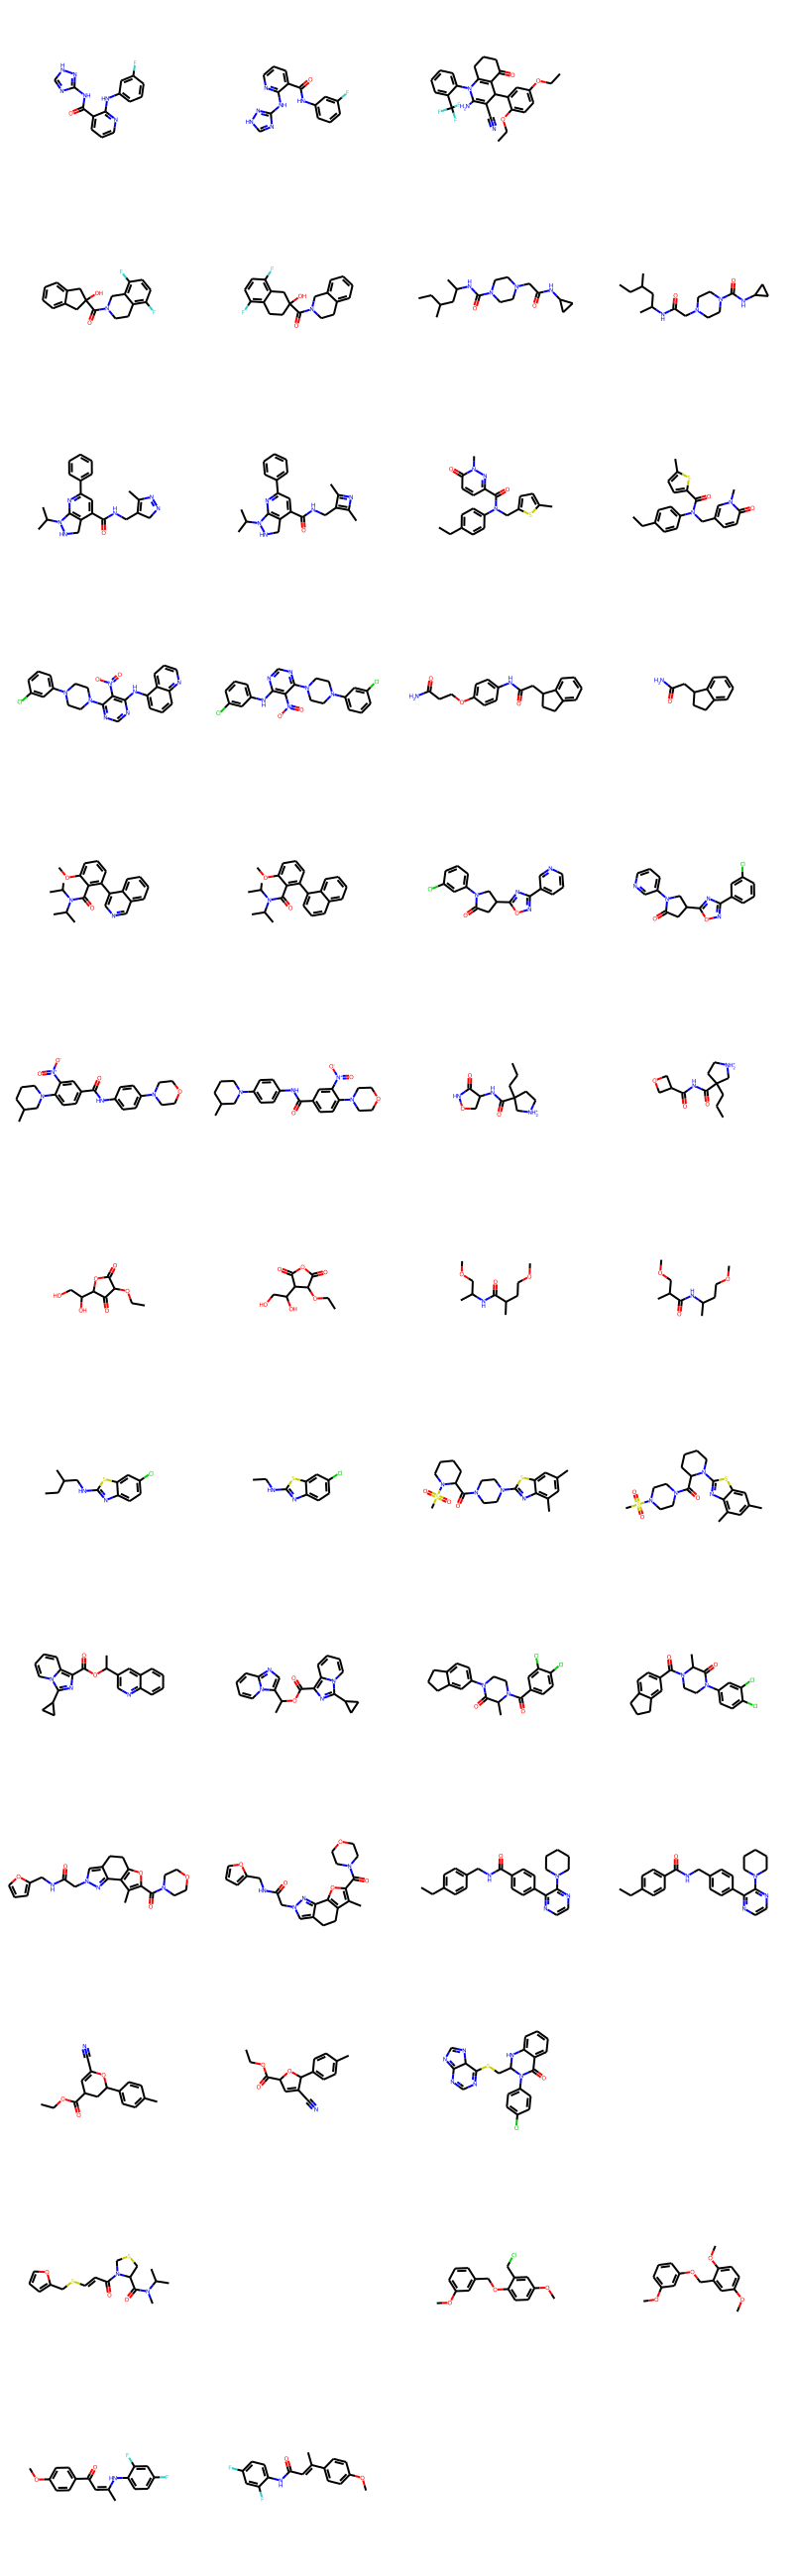

In [10]:
dmols = [Chem.MolFromSmiles(x) for x in dsmiles]
tmols = [Chem.MolFromSmiles(x) for x in tsmiles]

pmols = []
for i in range(len(dmols)):
    pmols += [tmols[i], dmols[i]]
    
Draw.MolsToGridImage(pmols[:50], molsPerRow=4)

# Similarities of Incorrect Mols

In [11]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import DataStructs


tmols_ = [x for i,x in enumerate(tmols) if dsmiles[i] != ""]
dmols_ = [x for i,x in enumerate(dmols) if dsmiles[i] != ""]

fps_tmols = [rdMolDescriptors.GetMorganFingerprintAsBitVect(x, 2) for x in tmols_]
fps_dmols = [rdMolDescriptors.GetMorganFingerprintAsBitVect(x, 2) for x in dmols_]
sim = [DataStructs.TanimotoSimilarity(fps_tmols[i], fps_dmols[i]) for i in range(len(fps_tmols))]

In [12]:
print("mean: %1.2f"%np.mean(sim))
print("std: %1.2f"%np.std(sim))
print("max: %1.2f"%np.max(sim))
print("min: %1.2f"%np.min(sim))

mean: 0.71
std: 0.17
max: 1.00
min: 0.20


(array([ 2.,  5., 16., 30., 75., 74., 57., 67., 60., 47.]),
 array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ]),
 <BarContainer object of 10 artists>)

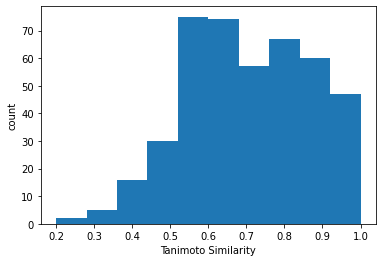

In [13]:
from matplotlib import pyplot
pyplot.xlabel("Tanimoto Similarity")
pyplot.ylabel("count")
pyplot.hist(sim)

# Accuracy-MolWeight

In [14]:
from rdkit.Chem import Descriptors

true_mols = [Chem.MolFromSmiles(x) for x in true_smiles]
mw = [Descriptors.ExactMolWt(x) for x in true_mols]

print(min(mw), max(mw))

154.06626854809 499.1863630040899


In [15]:
smiles_match = [re_can_smiles[i] == true_smiles[i] for i in range(len(true_smiles))]
mw_ = [int(np.ceil(m/50))*50 for m in mw]
x = [mw_, smiles_match]
x = list(map(list, zip(*x)))
x = sorted(x)
mw_, smiles_match = list(map(list,zip(*x)))
mw_count = [mw_.count(i*50) for i in range(4,11)]

num =0
accuracy = []
for c in mw_count:
    accuracy.append(sum(smiles_match[num:num+c])/c)
    num += c
    
accuracy

[0.7894736842105263,
 0.8821989528795812,
 0.9179841897233202,
 0.9213973799126638,
 0.9119047619047619,
 0.8140495867768595,
 0.7926829268292683]

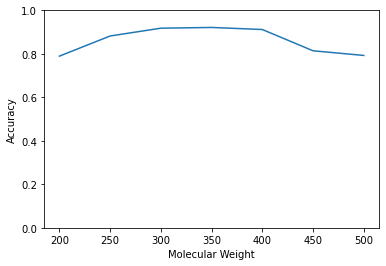

In [16]:
from matplotlib import pyplot

pyplot.xlabel("Molecular Weight")
pyplot.ylabel("Accuracy")
pyplot.ylim([0,1])
pyplot.plot([i*50 for i in range(4,11)], accuracy)

(array([ 109.,  399., 1028., 1631., 1201.,  466.,  166.]),
 array([154.06626855, 203.36913918, 252.67200982, 301.97488046,
        351.27775109, 400.58062173, 449.88349237, 499.186363  ]),
 <BarContainer object of 7 artists>)

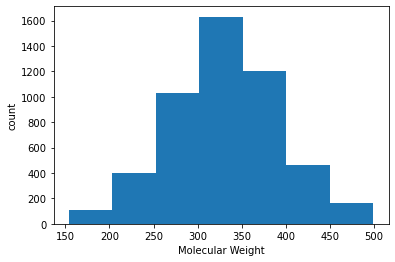

In [17]:
pyplot.ylabel("count")
pyplot.xlabel("Molecular Weight")
pyplot.hist(mw, 7)

# Matched Molecular Pair (MMP) Conversion

In [18]:
df = pd.read_csv("Data/MMP/train.csv")
smol = [Chem.MolFromSmiles(x) for x in df["Source_Mol"]]
tmol = [Chem.MolFromSmiles(x) for x in df["Target_Mol"]]

sfp = [rdMolDescriptors.GetHashedMorganFingerprint(x,2, fp_bits).GetNonzeroElements() for x in smol]
tfp = [rdMolDescriptors.GetHashedMorganFingerprint(x,2, fp_bits).GetNonzeroElements() for x in tmol]

sk = [list(x.keys()) for x in sfp]
sv = [list(x.values()) for x in sfp]
tk = [list(x.keys()) for x in tfp]
tv = [list(x.values()) for x in tfp]

sa = np.zeros([len(sk), fp_bits], dtype=np.int32)
ta = np.zeros([len(tk), fp_bits], dtype=np.int32)

for i,x in enumerate(sk):
    for j,y in enumerate(x):
        sa[i][y]=sv[i][j]
    
for i,x in enumerate(tk):
    for j,y in enumerate(x):
        ta[i][y]=tv[i][j]

[  41  141  255  325  384  465  656  699  843  862  875 1032 1088 1088
 1211 1224 1233 1357 1380 1380 1380 1380 1380 1380 1417 1685 1917 1928
 2081 2128 2162 2166 2440 2440 2440 2698 2703 2855 3105 3105 3105 3200
 3247 3247 3387 3397 3628 3713 3744 3798 3798 3798 3798 3804 3856 3858
 3864 3888 3921 3921 3921 3921 3921 3921 3921 3921 3996]


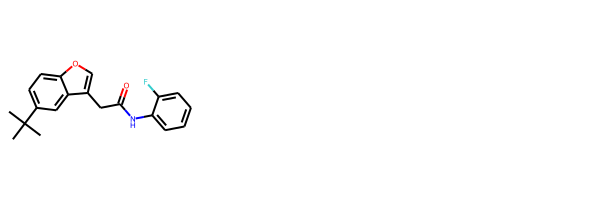

In [19]:
mol = Chem.MolFromSmiles(true_smiles[0])
fp = rdMolDescriptors.GetHashedMorganFingerprint(mol,2,fp_bits).GetNonzeroElements()
fpa = np.zeros([fp_bits], dtype=np.int32)
fpk = list(fp.keys())
fpv = list(fp.values())

for i,x in enumerate(fpk):
    fpa[x] = fpv[i]
    
print(np.array([i for i,y in enumerate(fpa) for z in range(y)]))
Draw.MolsToGridImage([mol])

In [20]:
fpa = fpa + ta - sa
flags = fpa<0
flags = [True not in x for x in flags]

f = [x.split(">>") for x in df["Transformation"]]
f = [x for i,x in enumerate(f) if flags[i]]
fpa_ = fpa[flags]

f1, f2 = list(map(list, zip(*f)))
f1 = [Chem.MolFromSmiles(x) for x in f1]
f2 = [Chem.MolFromSmiles(x) for x in f2]
fpa.shape

[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:11:34] WARNING: not removing hydrogen atom with

(160831, 4096)

In [21]:
da = ta-sa
da[3370]

da_array = []

for i,x in enumerate(da[3370]):
    if x>=0:
        for j in range(x):
            da_array.append(i)
    else:
        for j in range(-x):
            da_array.append(-i)
            
print(np.array(da_array))

[  197   235   235   638  -699  -862 -1032 -1088 -1088 -1211 -1224  1823
  1920 -1928  2128  2303  2358  2358  2381  3105 -3247 -3247  3558  3621
 -3744  3770  3798  3798  3802 -3804 -3864 -3888 -3996]


In [22]:
from ChemUtils.PreProcessing import encode_to_array

fpa__ = [[i for i,y in enumerate(x) for z in range(y)] for x in fpa_]
fpa__ = encode_to_array(fpa__, fp_bits)
print("number of arrays with no negative factor:", fpa__.shape[0])
fpa__

number of arrays with no negative factor: 225


array([[4097,    3,   42, ...,    0,    0,    0],
       [4097,   42,  142, ...,    0,    0,    0],
       [4097,    3,   42, ...,    0,    0,    0],
       ...,
       [4097,   42,  142, ...,    0,    0,    0],
       [4097,   42,  142, ...,    0,    0,    0],
       [4097,   42,  142, ...,    0,    0,    0]], dtype=int32)

In [23]:
t = int(np.ceil(len(fpa__)/BATCH_SIZE))
outputs=[]
for i in range(t):
    start = i*BATCH_SIZE
    end = (i+1)*BATCH_SIZE
    if end>len(fpa__):
        end = len(fpa__)
    batch_size = end-start
    output, attention_weights = evaluate(transformer, fpa__[start:end], target_vocab_size-2, batch_size, 80)
    outputs.append(output)
    
    print("complete: %d/%d"%(i*BATCH_SIZE + batch_size, fpa__.shape[0]))

complete: 200/225
complete: 225/225


In [24]:
re_smiles = []
for output in outputs:
    re_smiles.extend(array_to_smiles(output.numpy(), target_vocab_size-1))

In [25]:
re_mols = [Chem.MolFromSmiles(x) for x in re_smiles]

f1 = [x for i,x in enumerate(f1) if re_mols[i] is not None]
f2 = [x for i,x in enumerate(f2) if re_mols[i] is not None]
re_mols = [x for x in re_mols if x is not None]
print("valid_smiles:%d"%len(re_mols))

draw_mols = []
for i in range(len(re_mols)):
    draw_mols.extend([mol, f1[i], f2[i], re_mols[i]])

valid_smiles:223


[16:11:52] SMILES Parse Error: extra close parentheses while parsing: CC1CCC(C)CC(Cc2coc3ccc(C(C)(C)C)cc23)(=O)Nc2ccccc2F)CC1
[16:11:52] SMILES Parse Error: Failed parsing SMILES 'CC1CCC(C)CC(Cc2coc3ccc(C(C)(C)C)cc23)(=O)Nc2ccccc2F)CC1' for input: 'CC1CCC(C)CC(Cc2coc3ccc(C(C)(C)C)cc23)(=O)Nc2ccccc2F)CC1'
[16:11:52] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1)N1CCC(N2CC1
[16:11:52] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1)N1CCC(N2CC1' for input: 'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1)N1CCC(N2CC1'


/usr/local/miniforge3/envs/DL/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


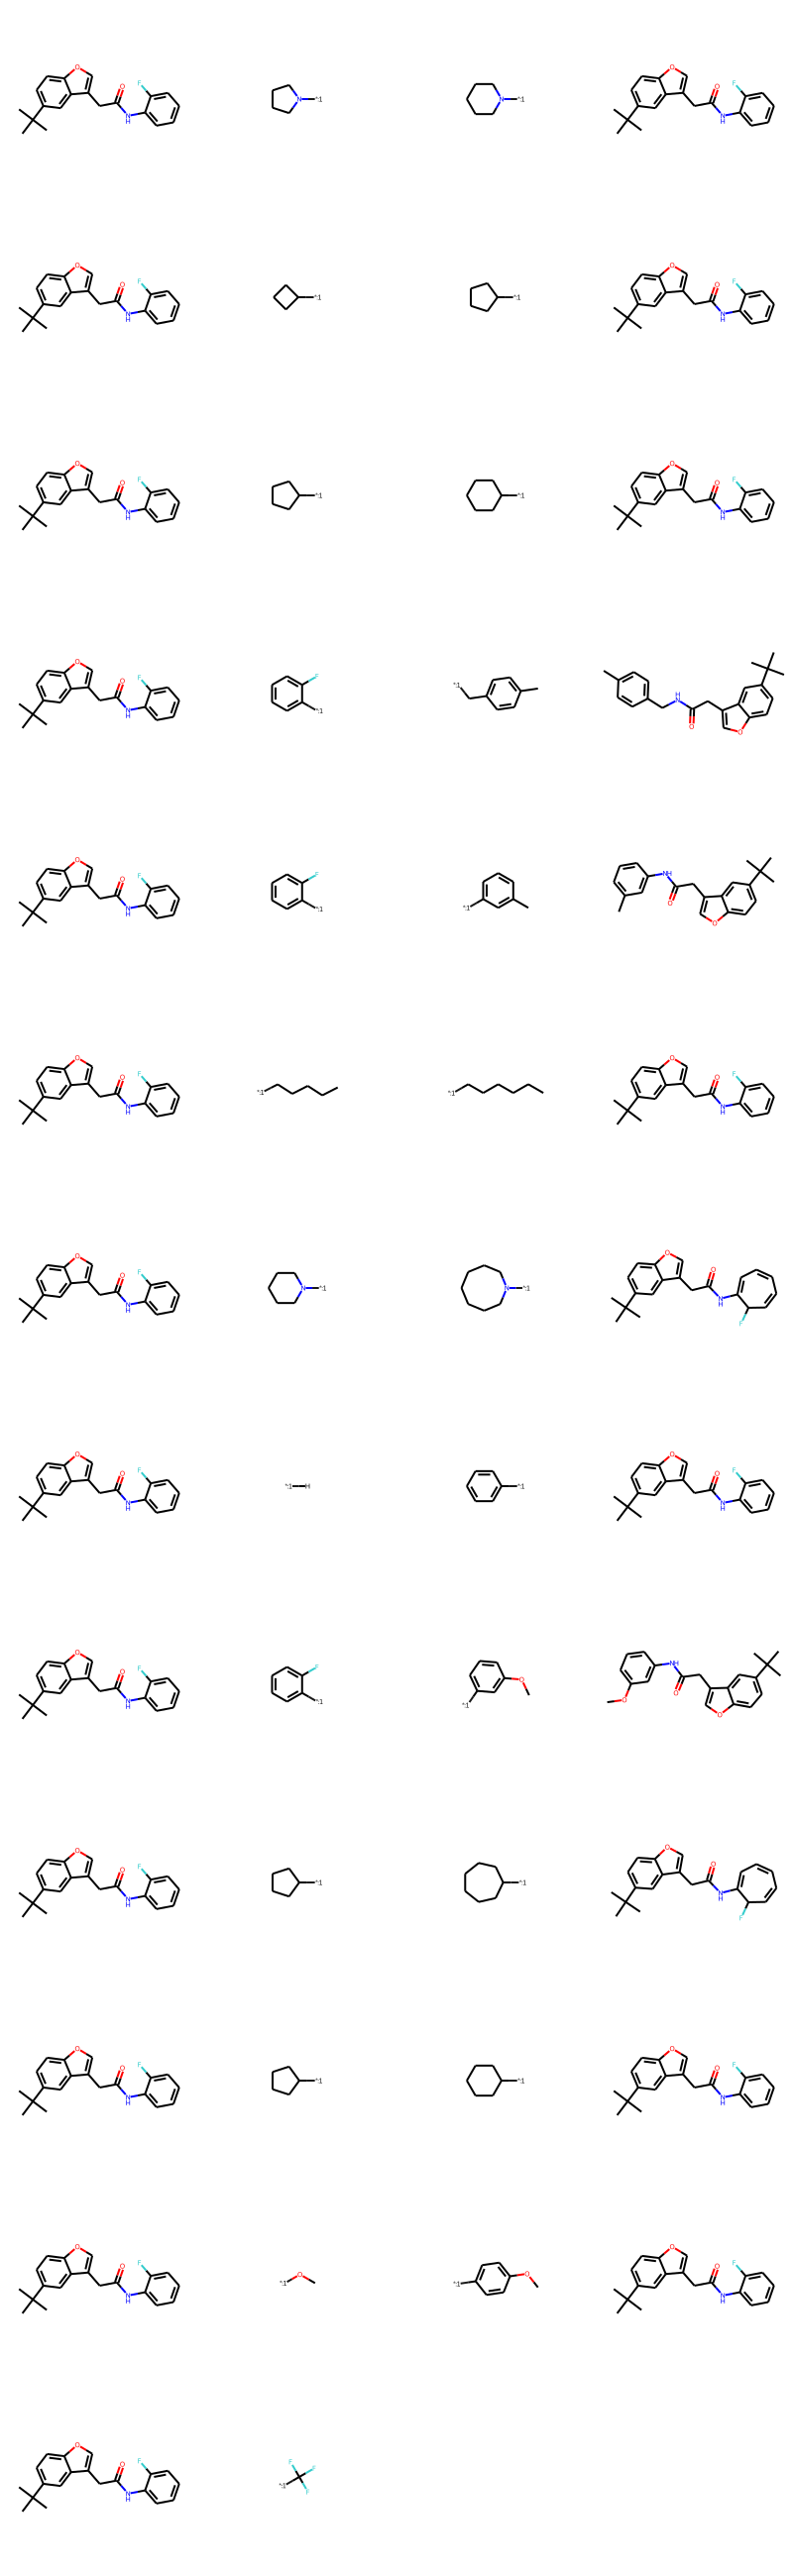

In [26]:
Draw.MolsToGridImage(draw_mols[0:100], molsPerRow=4)

In [27]:
re_mols_ = [x for x in re_mols if Chem.MolToSmiles(x)==Chem.MolToSmiles(mol)]
print("number of no-conversions:", len(re_mols_))
re_mols_ = [x for x in re_mols if Chem.MolToSmiles(x)!=Chem.MolToSmiles(mol)]
print("numver of conversions", len(re_mols_))

number of no-conversions: 106
numver of conversions 117


In [28]:
mat_mols = [[mol, f1[i], f2[i], re_mols[i]] for i,x in enumerate(re_mols) if Chem.MolToSmiles(x)!=Chem.MolToSmiles(mol)]
source, f1_, f2_, transformed=list(map(list, zip(*mat_mols)))

df = pd.DataFrame()
df["source"]=[Chem.MolToSmiles(x) for x in source]
df["f1"]=[Chem.MolToSmiles(x) for x in f1_]
df["f2"]=[Chem.MolToSmiles(x) for x in f2_]
df["transformed"]=[Chem.MolToSmiles(x) for x in transformed]

df = df.drop_duplicates(["source", "f1", "f2", "transformed"])
df.to_csv("MMPconversions.csv", index=False)

print("duplicates:", len(df))

duplicates: 73


/usr/local/miniforge3/envs/DL/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  warnings.warn(


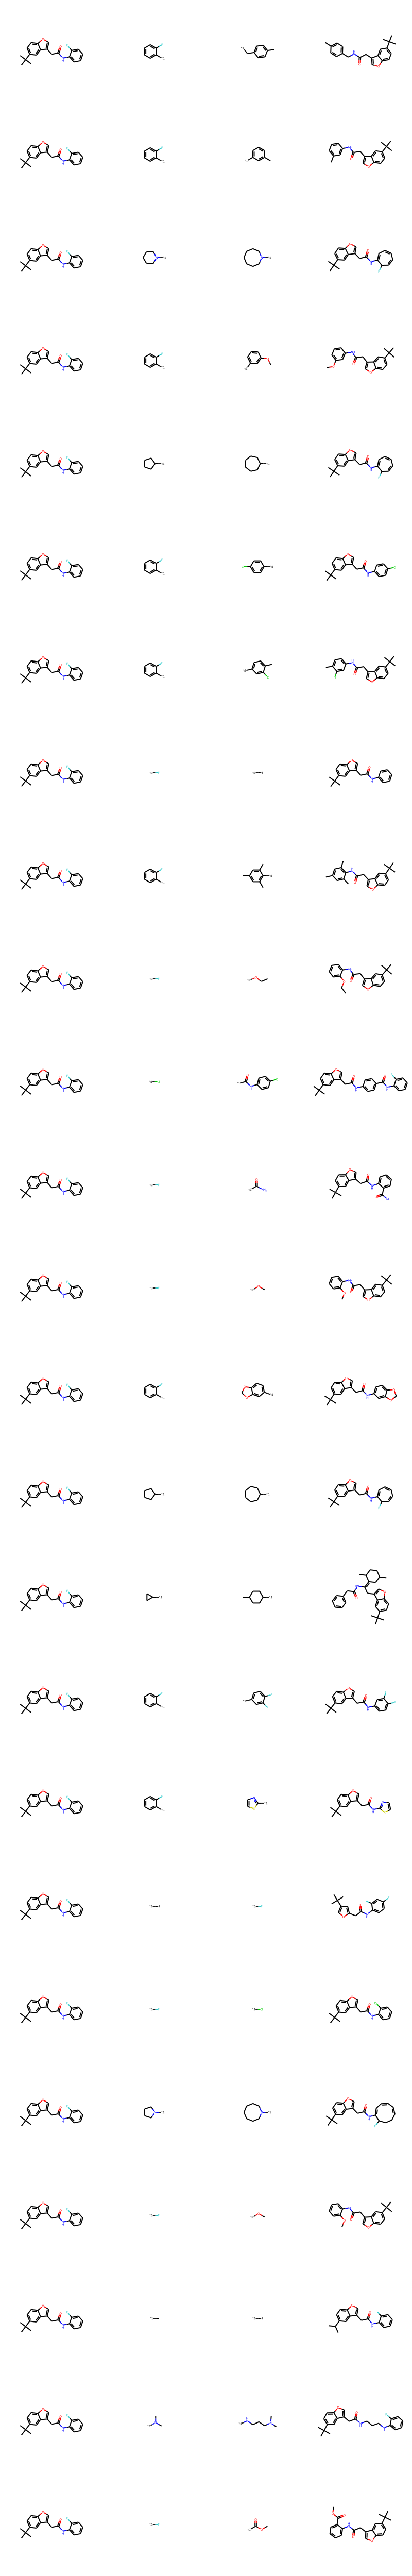

In [29]:
draw_mols = []
for i in range(len(source)):
    draw_mols.extend([source[i], f1_[i], f2_[i], transformed[i]])
Draw.MolsToGridImage(draw_mols, molsPerRow=4, maxMols=100)

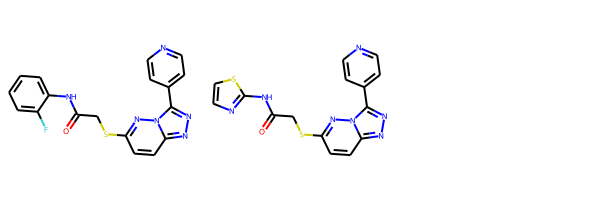

In [30]:
Draw.MolsToGridImage([smol[32651],tmol[32651]])

In [31]:
print("pre-LogP:",Descriptors.MolLogP(smol[32651]),"post-LogP:",Descriptors.MolLogP(tmol[32651]))

pre-LogP: 3.0562000000000005 post-LogP: 2.3735999999999997


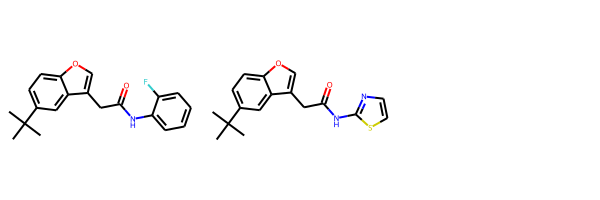

In [32]:
Draw.MolsToGridImage([mol, transformed[17]])

In [33]:
print("pre-LogP:",Descriptors.MolLogP(mol),"post-LogP:",Descriptors.MolLogP(transformed[17]))

pre-LogP: 5.050600000000004 post-LogP: 4.368000000000004
